## Tutorial: cell type deconvolution for mouse hippocampus dataset(Slide-seq V2 and Drop-seq)

In [1]:
import torch
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# from .util import permutation
import os
import random
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import sys
sys.path.insert(1, '/home/nas2/biod/myy/project/CLPLS_package')
from CLPLS.util import *
from CLPLS.process import process_sc, process_st
from CLPLS.train import train,PLSR

In [2]:
epochs = 200
dim_input = 620 #input dimension
beta = 0.1 #positive loss hyperparam
random_seed = 11
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

#read data
st_adata = sc.read_h5ad('/home/nas2/biod/myy/project/CLPLS_package/data/mouse_hippocampus/adata_st.h5ad')
sadj, graph_neigh, label_CSL = process_st(st_adata)

sc_adata = sc.read_h5ad('/home/nas2/biod/myy/project/CLPLS_package/data/mouse_hippocampus/adata_rna.h5ad')
ctype_lab, fadj = process_sc(sc_adata, "cell_type")

embedding_st, embedding_sc = train(dim_input=dim_input,hidden_channels=128,dim_output=50,nclass=17, st_adata=st_adata,graph_neigh=graph_neigh,spatial_graph=sadj,sc_adata=sc_adata,snn=fadj,ctype_lab=ctype_lab,label_CSL=label_CSL,epochs=epochs,beta=beta)

Graph with 39740 nodes and 117826 edges
[0 0 0 0 1 1 1 1 1 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 5]
[    2 16658 34943 ... 39576 39605 39644]
tensor([[    2, 16658, 34943,  ...,  5306,  7757, 32572],
        [    0,     0,     0,  ..., 39739, 39739, 39739]])
tensor([[    0,     0,     0,  ..., 15089, 15089, 15089],
        [   34,    41,   146,  ..., 14930, 14966, 14995]])
Begin to train ST data...


100%|██████████| 200/200 [05:03<00:00,  1.52s/it]


Optimization finished for ST data!
Training complete!
Embedding is saved 


In [3]:
df_projection = PLSR(sc_adata, st_adata, embedding_sc,embedding_st,component=10,label='cell_type')

/home/moyuanyuan/anaconda3/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


[<Axes: title={'center': 'CA1'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'CA3'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'Denate'}, xlabel='spatial1', ylabel='spatial2'>]

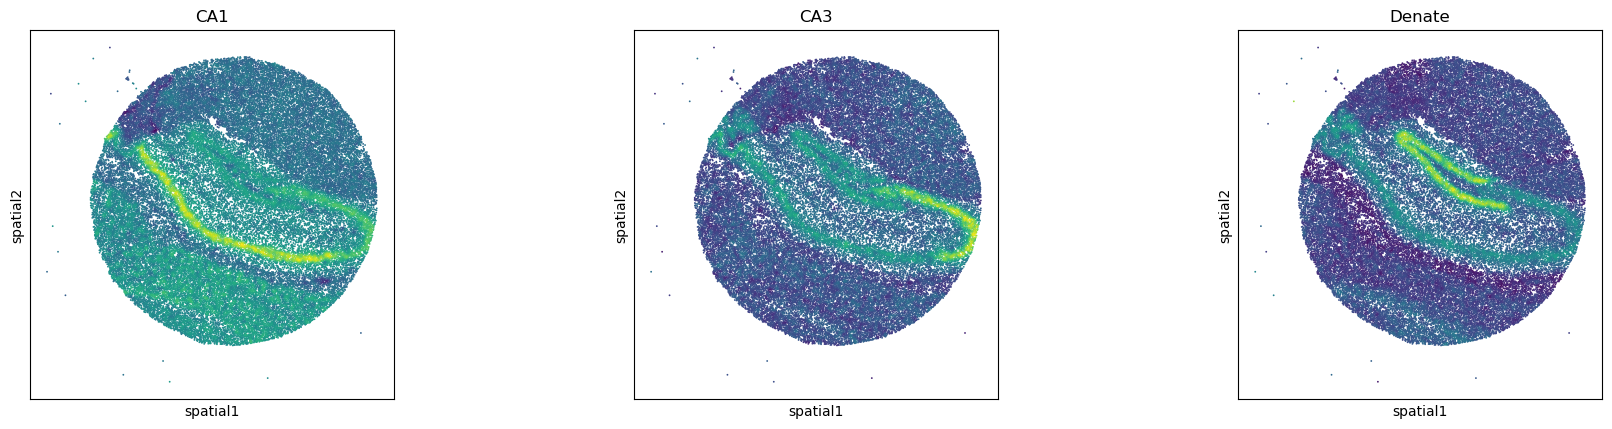

In [4]:
adata_st1 = st_adata.copy()
for i in range(17):
    adata_st1.obs[df_projection.columns.values[i]] = df_projection.values[:,i]
adata_st1.obsm['spatial'][:, 1] = -adata_st1.obsm['spatial'][:, 1]
type=['CA1','CA3','Denate']
sc.pl.spatial(adata_st1, spot_size=30, color=type,show=False,colorbar_loc=None)